# Creating hot gas density profiles and measuring gas mass

Though this work is generally concerned with detected absorption of background Quasar emission by warm gas in the intra-cluster/group medium, it also seemed appropriate to measure the quantity of hot, X-ray emitting, gas present in the intra-cluster medium. This involves creating a density profile, and there is a method (using surface brightness profiles) which can be used with low signal-to-noise extended sources. We then calculate the total gas mass by spherically integrating that profile within overdensity radii for all of our systems.

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
import os
from shutil import rmtree
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 10
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/radial_prof_analyses')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model
from xga.products import BaseAggregateProfile1D
from xga.utils import r500 as r500_unit
    
%matplotlib inline

## Setting up directories

Need to make sure that some of the directories that we will be storing output files and figures in actually exist:

In [2]:
if not os.path.exists('../../outputs/results/'):
    os.makedirs('../../outputs/results/')
    
if not os.path.exists('../../outputs/figures/gm_prop_comparisons/'):
    os.makedirs('../../outputs/figures/gm_prop_comparisons/')

## Reading the XGA sample files

We read in the files generated by our various runs of the XGA-LTR in another notebook in this repository. They contain the radii we measured, as well as all the other information that we need to declare an XGA ClusterSample:

In [3]:
r500_samp = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')
r500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r500_froztemp_pipeline_results.csv')

r2500_samp = pd.read_csv('../../outputs/results/ltr_r2500_pipeline_results.csv')
r2500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r2500_froztemp_pipeline_results.csv')

We show one of the dataframes to illustrate the contents:

In [4]:
r500_samp

,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,25124A,243.629055,26.730240,0.186,867.647767,39.128436,3.817000,0.287230,0.326195,7.396831e+43,1.360925e+42,1.402886e+42,2.126068e+44,1.169875e+43,7.694207e+42,4.240060,0.463875,0.698658,4.661778e+43,1.474055e+42,1.136021e+42,1.407295e+44,1.243112e+43,8.999482e+42
1,25124B,243.504000,26.691000,0.186,665.433860,93.790303,2.121080,0.453657,1.097385,4.858143e+42,5.199192e+41,8.079419e+41,1.105362e+43,1.375212e+42,1.947342e+42,1.668870,0.571085,1.111938,3.756145e+42,5.779736e+41,7.552022e+41,7.921396e+42,1.571571e+42,1.660467e+42
2,25124C,243.541000,26.648000,0.186,504.349762,26.563232,1.505450,0.118645,0.157002,4.980125e+42,3.866127e+41,5.769732e+41,1.016123e+43,9.850380e+41,1.368388e+42,1.475180,0.123717,0.146730,4.692879e+42,3.996000e+41,5.333483e+41,9.510069e+42,9.116242e+41,1.309781e+42
3,44739,229.793620,28.331750,0.118,426.978169,22.844914,1.024810,0.066587,0.081072,2.328422e+42,2.278838e+41,2.520566e+41,4.075968e+42,4.683800e+41,5.811503e+41,0.993314,0.088181,0.086573,1.873450e+42,2.306554e+41,2.767644e+41,3.233224e+42,3.960150e+41,4.341351e+41
4,19670AB,150.226402,50.800565,0.134,527.139938,30.952352,1.978950,0.341111,0.660766,3.495482e+42,3.820188e+41,5.467797e+41,7.810693e+42,9.568825e+41,1.398974e+42,1.561920,0.179030,0.293561,2.992024e+42,3.335254e+41,3.754196e+41,6.209580e+42,1.028791e+42,1.035156e+42
5,19670A,150.256710,50.793942,0.134,462.177328,27.670531,1.252010,0.113311,0.139826,1.581114e+42,2.128492e+41,3.223873e+41,3.026369e+42,7.463168e+41,7.445787e+41,1.333620,0.148756,0.199910,1.176707e+42,3.641293e+41,3.858331e+41,2.310265e+42,7.379632e+41,6.230597e+41
6,19670B,150.214920,50.805014,0.134,591.610814,44.926843,1.907300,0.243713,0.425694,4.533795e+42,3.011521e+41,5.608558e+41,1.001424e+43,9.733266e+41,1.244323e+42,1.652700,0.244968,0.313360,3.512372e+42,3.266195e+41,5.632695e+41,7.421187e+42,8.747499e+41,8.987884e+41
7,19670C,150.065000,50.746000,0.134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19670D,150.168000,50.686000,0.134,359.762893,58.758058,0.326002,0.070427,0.247115,7.776962e+41,4.208098e+41,1.206647e+41,1.484812e+42,7.575129e+41,3.734298e+41,0.246174,0.060497,0.107147,6.906259e+41,4.756693e+41,1.577939e+41,1.729986e+42,1.048810e+42,5.710794e+41
9,12833A,129.496800,44.248700,0.145,484.161429,22.267250,1.394590,0.098024,0.113226,3.419655e+42,4.326240e+41,2.991426e+41,6.828256e+42,9.969550e+41,7.096560e+41,1.416080,0.145301,0.239000,2.240773e+42,3.645432e+41,2.770394e+41,4.498901e+42,7.032202e+41,5.884023e+41


We remove the two entries with NaN $R_{500}$ values:

In [5]:
r500_samp = r500_samp[~np.isnan(r500_samp['r500'])].reset_index(drop=True)
r500_samp

,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,25124A,243.629055,26.730240,0.186,867.647767,39.128436,3.817000,0.287230,0.326195,7.396831e+43,1.360925e+42,1.402886e+42,2.126068e+44,1.169875e+43,7.694207e+42,4.240060,0.463875,0.698658,4.661778e+43,1.474055e+42,1.136021e+42,1.407295e+44,1.243112e+43,8.999482e+42
1,25124B,243.504000,26.691000,0.186,665.433860,93.790303,2.121080,0.453657,1.097385,4.858143e+42,5.199192e+41,8.079419e+41,1.105362e+43,1.375212e+42,1.947342e+42,1.668870,0.571085,1.111938,3.756145e+42,5.779736e+41,7.552022e+41,7.921396e+42,1.571571e+42,1.660467e+42
2,25124C,243.541000,26.648000,0.186,504.349762,26.563232,1.505450,0.118645,0.157002,4.980125e+42,3.866127e+41,5.769732e+41,1.016123e+43,9.850380e+41,1.368388e+42,1.475180,0.123717,0.146730,4.692879e+42,3.996000e+41,5.333483e+41,9.510069e+42,9.116242e+41,1.309781e+42
3,44739,229.793620,28.331750,0.118,426.978169,22.844914,1.024810,0.066587,0.081072,2.328422e+42,2.278838e+41,2.520566e+41,4.075968e+42,4.683800e+41,5.811503e+41,0.993314,0.088181,0.086573,1.873450e+42,2.306554e+41,2.767644e+41,3.233224e+42,3.960150e+41,4.341351e+41
4,19670AB,150.226402,50.800565,0.134,527.139938,30.952352,1.978950,0.341111,0.660766,3.495482e+42,3.820188e+41,5.467797e+41,7.810693e+42,9.568825e+41,1.398974e+42,1.561920,0.179030,0.293561,2.992024e+42,3.335254e+41,3.754196e+41,6.209580e+42,1.028791e+42,1.035156e+42
5,19670A,150.256710,50.793942,0.134,462.177328,27.670531,1.252010,0.113311,0.139826,1.581114e+42,2.128492e+41,3.223873e+41,3.026369e+42,7.463168e+41,7.445787e+41,1.333620,0.148756,0.199910,1.176707e+42,3.641293e+41,3.858331e+41,2.310265e+42,7.379632e+41,6.230597e+41
6,19670B,150.214920,50.805014,0.134,591.610814,44.926843,1.907300,0.243713,0.425694,4.533795e+42,3.011521e+41,5.608558e+41,1.001424e+43,9.733266e+41,1.244323e+42,1.652700,0.244968,0.313360,3.512372e+42,3.266195e+41,5.632695e+41,7.421187e+42,8.747499e+41,8.987884e+41
7,19670D,150.168000,50.686000,0.134,359.762893,58.758058,0.326002,0.070427,0.247115,7.776962e+41,4.208098e+41,1.206647e+41,1.484812e+42,7.575129e+41,3.734298e+41,0.246174,0.060497,0.107147,6.906259e+41,4.756693e+41,1.577939e+41,1.729986e+42,1.048810e+42,5.710794e+41
8,12833A,129.496800,44.248700,0.145,484.161429,22.267250,1.394590,0.098024,0.113226,3.419655e+42,4.326240e+41,2.991426e+41,6.828256e+42,9.969550e+41,7.096560e+41,1.416080,0.145301,0.239000,2.240773e+42,3.645432e+41,2.770394e+41,4.498901e+42,7.032202e+41,5.884023e+41
9,12833B,129.445000,44.379000,0.145,435.477156,26.364544,1.161630,0.135227,0.116765,2.511945e+42,2.677573e+41,3.283677e+41,4.654556e+42,7.296128e+41,8.407739e+41,0.926943,0.120020,0.134047,1.378771e+42,3.555113e+41,3.233896e+41,2.309754e+42,5.456964e+41,3.761557e+41


## Setting up an XGA ClusterSample

We set up an XGA ClusterSample object for our systems - this will allow us to easily interact with all the XMM data for these objects, and perform measurements of their hot-gas density profiles. We make sure to set `use_peak=False`, so that the user defined coordinate (UDC) is used as the central position, as some of these systems are low enough signal to noise that they may produce unreliable peak coordinates:

In [6]:
srcs = ClusterSample(r500_samp['ra'].values, r500_samp['dec'].values, r500_samp['redshift'].values, 
                     r500_samp['name'].values, r500=Quantity(r500_samp['r500'].values, 'kpc'), 
                     use_peak=False, load_fits=True)
srcs.info()
srcs.suppressed_warnings

Setting up Galaxy Clusters: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


-----------------------------------------------------
Number of Sources - 14
Redshift Information - True
Sources with ≥1 detection - 12 [86%]
-----------------------------------------------------




/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:308: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


{'44739': ['There are 1 alternative matches for observation 0900700201, associated with source 44739'],
 '19670A': ['There are 1 alternative matches for observation 0861080101, associated with source 19670A'],
 '19670B': ['A point source has been detected in 0861080101 and is very close to the user supplied coordinates of 19670B. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 'J215504.8-093520': ["J215504.8-093520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"],
 'J215437.2-091532.4': ['A PSF sized extended source has been detected in 0204310101 and is very close to the user supplied coordinates of J215437.2-091532.4. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 '50433': ['There are 1 alternative matches for observation 0102040301, associated with source 50433']}

## Generating hot gas density profiles

We generate surface brightness profiles, from ratemaps that have been corrected for the spatially varying PSF, and fit a simple $\beta$ model to them. This is inverse Abel transformed to recover a 3D emissivity profile, which in turn is used to calculate a 3D hot-baryon density profile with assumptions made about the emission model for the gas.

We have decided to generate the profiles to an outer radius of $1R_{500}$, where the $R_{500}$ in question is that measured from the 'standard' XGA-LTR run. As this process requires spectral information to work, we tell it to use `min_counts=25`, so that it should use previously generated spectra. 

We're also going to pass the temperatures that were measured by the XGA-LTR, so as to be totally consistent (there we used a non-standard energy range for the spectral fits that we cannot pass to this function currently):

In [7]:
txs = Quantity([r500_samp[r500_samp['name'] == src.name].iloc[0]['Tx500'] for src in srcs], 'keV')
txs

<Quantity [3.817   , 2.12108 , 1.50545 , 1.02481 , 1.97895 , 1.25201 ,
           1.9073  , 0.326002, 1.39459 , 1.16163 , 2.01986 , 1.72782 ,
           0.350344, 1.26242 ] keV>

Then we run the actual density profile generation:

In [8]:
rl_psf(srcs, bins=10)
d_profs = inv_abel_fitted_model(srcs, 'beta', outer_radius=srcs.r500, psf_bins=10, pix_step=2, min_counts=25, 
                                conv_temp=txs)

/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:157: UserWarning: All XSPEC operations had already been run.
  cluster_cr_conv(sources, conv_outer_radius, inner_radius, temps, abund_table=abund_table, num_cores=num_cores,
Fitting data, inverse Abel transforming, and measuring densities:  93%|█████████▎| 13/14 [03:57<00:18, 18.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 497.1996142  1128.23754508 1083.46390816]


Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████| 14/14 [04:14<00:00, 18.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [166.57303739 922.43184673 782.98245056]


Viewing the surface brightness profiles:

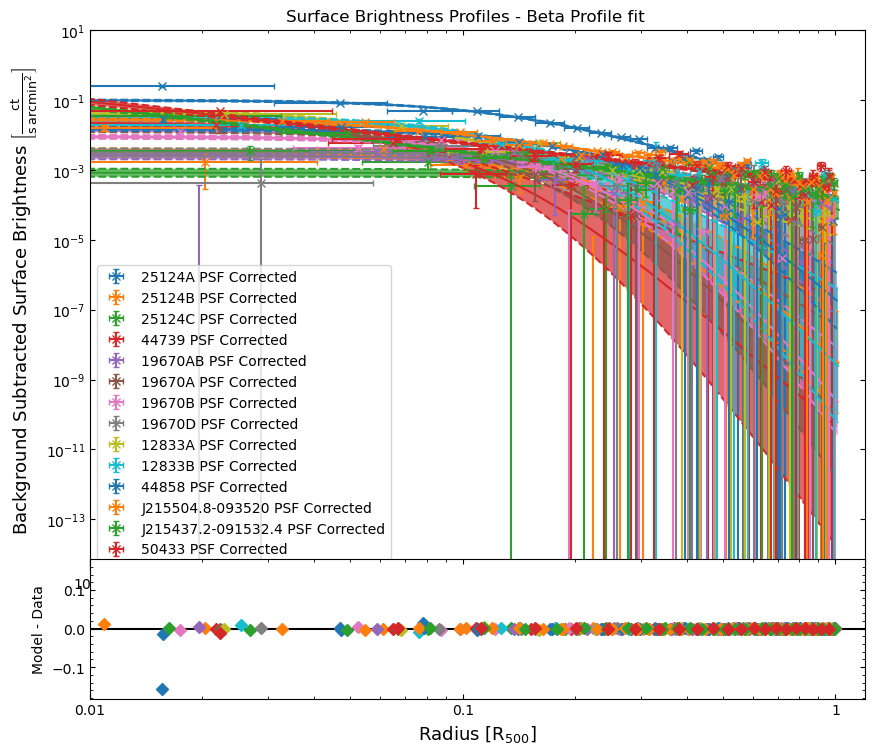

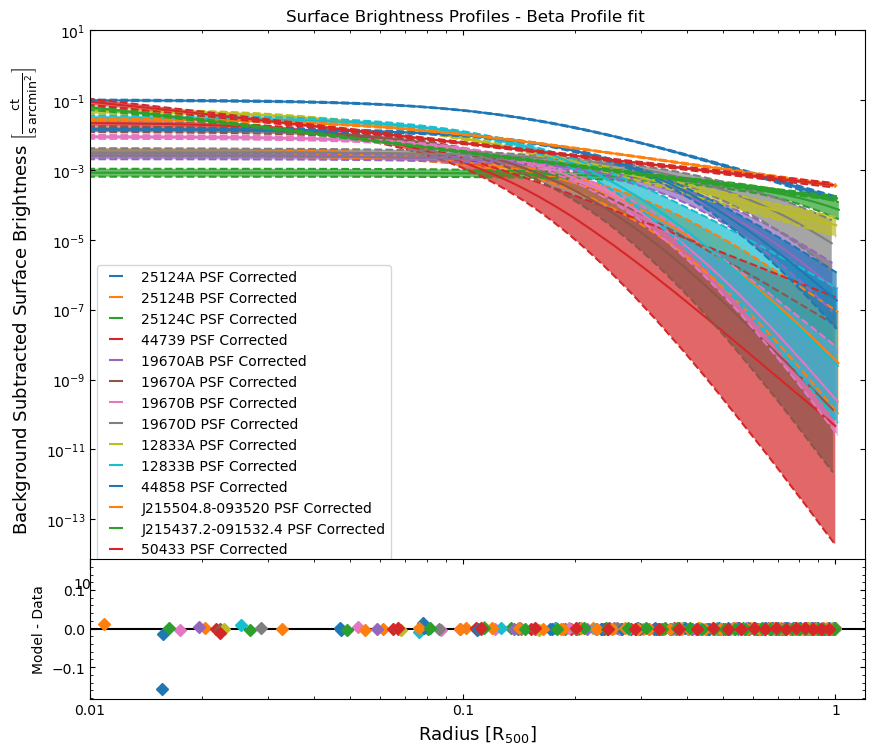

In [9]:
sb_profs = []
for dp in d_profs:
    if dp is not None:
        dp.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        dp.generation_profile.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        sb_profs.append(dp.generation_profile)

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
BaseAggregateProfile1D(sb_profs).view(model='beta', just_model=False, x_norm=True, axis_formatters=forms, 
                                      xlim=[0.01, 1.2], save_path='../../outputs/figures/sb_profs.pdf')
BaseAggregateProfile1D(sb_profs).view(model='beta', just_model=True, x_norm=True, axis_formatters=forms, 
                                      xlim=[0.01, 1.2], save_path='../../outputs/figures/sb_profs_justmod.pdf')

We also view the generated density profiles on one figure, and then save it to disk:

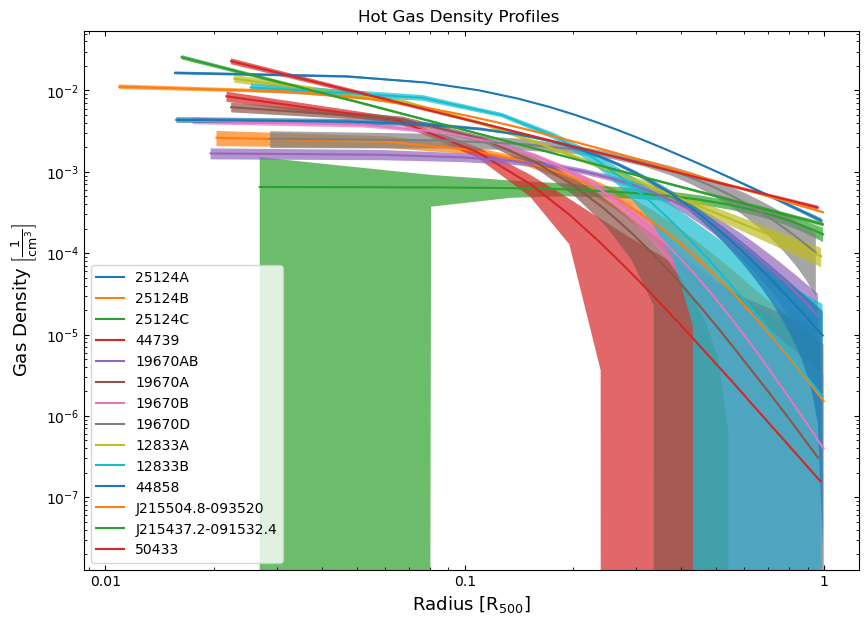

In [10]:
agg_dp = BaseAggregateProfile1D([dp for dp in d_profs if dp is not None])

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
agg_dp.view(joined_points=True, custom_title='Hot Gas Density Profiles', x_norm=True, axis_formatters=forms,
            save_path='../../outputs/figures/hot_gas_dens_profs.pdf')

## Showing brightness profile model parameters

We want to save the model parameters that describe each surface brightness profile to disk in a table (rather than just in the profile objects that XGA automatically saves to disk):

In [11]:
data = []
cols = ['name', 'beta', 'beta-', 'beta+', 'r_core', 'r_core-', 'r_core+','norm', 'norm-', 'norm+']
for src_ind, src in enumerate(srcs):
    if d_profs[src_ind] is not None:
        sb = d_profs[src_ind].generation_profile
        mod = sb.get_model_fit('beta', 'mcmc')
        par_vals = mod.model_pars
        par_errs = mod.model_par_errs
        cur_dat = [src.name, par_vals[0].value, *par_errs[0].value, par_vals[1].value, *par_errs[1].value, 
                   par_vals[2].value, *par_errs[2].value]
    else:
        cur_dat = [src.name] + [np.NaN]*9
    data.append(cur_dat)

print(mod.par_names)
print(mod.par_units)
    
sb_mod_df = pd.DataFrame(data, columns=cols).round(3)
sb_mod_df.to_csv("../../outputs/results/sb_beta_mod_pars.csv", index=False)
sb_mod_df

['beta', 'r_core', 'norm']
[Unit(dimensionless), Unit("kpc"), Unit("ct / (s arcmin2)")]


,name,beta,beta-,beta+,r_core,r_core-,r_core+,norm,norm-,norm+
0,25124A,0.718,0.028,0.031,122.944,8.506,9.011,0.100,0.004,0.005
1,25124B,2.062,0.769,0.626,202.735,58.963,59.432,0.003,0.001,0.001
2,25124C,1.967,0.971,0.621,654.565,248.415,191.891,0.001,0.000,0.000
3,44739,1.720,0.822,0.886,46.774,20.024,15.841,0.024,0.005,0.005
4,19670AB,2.109,0.733,0.575,273.567,69.408,62.643,0.003,0.000,0.001
5,19670A,1.983,0.802,0.660,84.796,26.147,21.724,0.015,0.003,0.003
6,19670B,2.270,0.682,0.461,158.536,32.634,22.869,0.009,0.001,0.001
7,19670D,1.875,0.866,0.759,225.079,81.512,82.762,0.003,0.001,0.001
8,12833A,0.621,0.050,0.071,29.146,5.047,6.369,0.051,0.008,0.009
9,12833B,1.933,0.784,0.709,96.083,29.758,22.296,0.031,0.005,0.006


In [12]:
form_str = "${v}^{{+{p}}}_{{-{m}}}$"

tab_str = ""
for row_ind, row in sb_mod_df.iterrows():
    row_val = row.values.astype(str)
    beta_str = form_str.format(v=row_val[1], m=row_val[2], p=row_val[3])
    rc_str = form_str.format(v=row_val[4], m=row_val[5], p=row_val[6])
    n_str = form_str.format(v=row_val[7], m=row_val[8], p=row_val[9])    

    cur_line = row_val[0] + ' & ' + beta_str + ' & ' + rc_str + ' & ' + n_str + '\\\[1.5mm]\n%\n'
    tab_str += cur_line
print(tab_str)

25124A & $0.718^{+0.031}_{-0.028}$ & $122.944^{+9.011}_{-8.506}$ & $0.1^{+0.005}_{-0.004}$\\[1.5mm]
%
25124B & $2.062^{+0.626}_{-0.769}$ & $202.735^{+59.432}_{-58.963}$ & $0.003^{+0.001}_{-0.001}$\\[1.5mm]
%
25124C & $1.967^{+0.621}_{-0.971}$ & $654.565^{+191.891}_{-248.415}$ & $0.001^{+0.0}_{-0.0}$\\[1.5mm]
%
44739 & $1.72^{+0.886}_{-0.822}$ & $46.774^{+15.841}_{-20.024}$ & $0.024^{+0.005}_{-0.005}$\\[1.5mm]
%
19670AB & $2.109^{+0.575}_{-0.733}$ & $273.567^{+62.643}_{-69.408}$ & $0.003^{+0.001}_{-0.0}$\\[1.5mm]
%
19670A & $1.983^{+0.66}_{-0.802}$ & $84.796^{+21.724}_{-26.147}$ & $0.015^{+0.003}_{-0.003}$\\[1.5mm]
%
19670B & $2.27^{+0.461}_{-0.682}$ & $158.536^{+22.869}_{-32.634}$ & $0.009^{+0.001}_{-0.001}$\\[1.5mm]
%
19670D & $1.875^{+0.759}_{-0.866}$ & $225.079^{+82.762}_{-81.512}$ & $0.003^{+0.001}_{-0.001}$\\[1.5mm]
%
12833A & $0.621^{+0.071}_{-0.05}$ & $29.146^{+6.369}_{-5.047}$ & $0.051^{+0.009}_{-0.008}$\\[1.5mm]
%
12833B & $1.933^{+0.709}_{-0.784}$ & $96.083^{+22.296}_{-29.758

<>:10: SyntaxWarning: invalid escape sequence '\['
<>:10: SyntaxWarning: invalid escape sequence '\['
/tmp/local/48014095/ipykernel_1140215/3910071147.py:10: SyntaxWarning: invalid escape sequence '\['
  cur_line = row_val[0] + ' & ' + beta_str + ' & ' + rc_str + ' & ' + n_str + '\\\[1.5mm]\n%\n'


## Measuring hot gas mass

Now that we have generated 3D density profiles, it is trivial to calculate the gas mass enclosed within some radii. This is done for the $R_{500}$ and $R_{2500}$ results of the three different ways that we ran the XGA-LTR:

In [13]:
gm500 = []
gm2500 = []
froztemp_gm500 = []
froztemp_gm2500 = []

for dp in d_profs:
    if dp is not None:
        rel_src = srcs[dp.src_name]
        dp.fit('king', progress_bar=False)
        r500_err = Quantity(r500_samp[r500_samp['name'] == rel_src.name].iloc[0]['r500+-'], 'kpc')
        gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
        
        rel_rad = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500'], 'kpc')
        rel_rad_err = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500+-'], 'kpc')
        gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        rel_rad = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == rel_src.name].iloc[0]['r500'], 'kpc')
        rel_rad_err = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == 
                                                  rel_src.name].iloc[0]['r500+-'], 'kpc')
        froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        
        rel_rad = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == rel_src.name].iloc[0]['r2500'], 
                           'kpc')
        rel_rad_err = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == 
                                                   rel_src.name].iloc[0]['r2500+-'], 'kpc')
        froztemp_gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
    else:
        null_res = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        gm500.append(null_res)
        gm2500.append(null_res)
        froztemp_gm500.append(null_res)
        froztemp_gm2500.append(null_res)
    
gm500 = Quantity(gm500)
gm500[gm500 == 0] = np.NaN
gm2500 = Quantity(gm2500)
gm2500[gm2500 == 0] = np.NaN

froztemp_gm500 = Quantity(froztemp_gm500)
froztemp_gm500[froztemp_gm500 == 0] = np.NaN
froztemp_gm2500 = Quantity(froztemp_gm2500)
froztemp_gm2500[froztemp_gm2500 == 0] = np.NaN

/tmp/local/48014095/ipykernel_1140215/1280221148.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/48014095/ipykernel_1140215/1280221148.py:20: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
/tmp/local/48014095/ipykernel_1140215/1280221148.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/48014095/ipykernel_1140215/1280221148.py:11: UserWarning: The outer radius you supplied is greater than

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 579.12291408 2617.35547737 2673.73544506]


/tmp/local/48014095/ipykernel_1140215/1280221148.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/48014095/ipykernel_1140215/1280221148.py:20: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 546.32883862 2542.12621273 2509.90366792]


/tmp/local/48014095/ipykernel_1140215/1280221148.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/48014095/ipykernel_1140215/1280221148.py:20: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])


## Saving gas masses

Now that we have measured the gas masses, we wish to save them to a csv:

In [14]:
gm_data = (np.hstack([gm500, gm2500, froztemp_gm500, 
                     froztemp_gm2500]).value / 1e+13).round(4)
gm_data = np.hstack([srcs.names[..., None], gm_data])

gm_cols = ['name', 'gm500', 'gm500-', 'gm500+', 'gm2500', 'gm2500-', 'gm2500+', 
           'gm_froztemp500', 'gm_froztemp500-', 'gm_froztemp500+', 'gm_froztemp2500', 'gm_froztemp2500-', 
           'gm_froztemp2500+']

gm_pd = pd.DataFrame(gm_data, columns=gm_cols)
gm_pd.to_csv("../../outputs/results/all_hot_gm_measurements.csv", index=False)
gm_pd

,name,gm500,gm500-,gm500+,gm2500,gm2500-,gm2500+,gm_froztemp500,gm_froztemp500-,gm_froztemp500+,gm_froztemp2500,gm_froztemp2500-,gm_froztemp2500+
0,25124A,2.6943,0.1392,0.1378,0.9038,0.0464,0.0447,2.7098,0.0555,0.0558,1.0504,0.0224,0.0217
1,25124B,0.0715,0.0087,0.0089,0.0566,0.0054,0.0058,0.0701,0.008,0.008,0.0518,0.0043,0.0046
2,25124C,0.2309,0.0222,0.0236,0.0634,0.01,0.0113,0.2829,0.0197,0.0219,0.0506,0.0052,0.0055
3,44739,0.005,0.0009,0.0015,0.0049,0.0008,0.0011,0.005,0.0009,0.0015,0.0049,0.0008,0.0013
4,19670AB,0.0986,0.0067,0.0071,0.0597,0.0048,0.0049,0.0991,0.0066,0.0071,0.0576,0.0036,0.0036
5,19670A,0.0143,0.0019,0.0024,0.0138,0.0015,0.0017,0.0143,0.0019,0.0024,0.0138,0.0016,0.0017
6,19670B,0.0458,0.003,0.0032,0.0419,0.0021,0.0021,0.0457,0.003,0.0031,0.0407,0.0019,0.0019
7,19670D,0.0886,0.0122,0.0136,0.0779,0.0101,0.0102,0.1019,0.0128,0.0159,0.0649,0.005,0.0052
8,12833A,0.1527,0.0103,0.0109,0.0573,0.0031,0.0032,0.1812,0.0116,0.0125,0.0729,0.0037,0.0038
9,12833B,0.0386,0.0048,0.0064,nan,nan,nan,0.0387,0.0049,0.0069,nan,nan,nan


## Comparing hot gas masses

As discussed in the XGA-LTR notebook elsewhere in this repository, we have run the pipeline which measures overdensity radii in three different modes, which results in slightly different values - as we measure the hot gas mass within a particular radius we compare the results from all the different versions of $R_{500}$ and $R_{2500}$:

In [15]:
stand_col = 'tab:cyan'
froztemp_col = 'firebrick'

### $R_{500}$

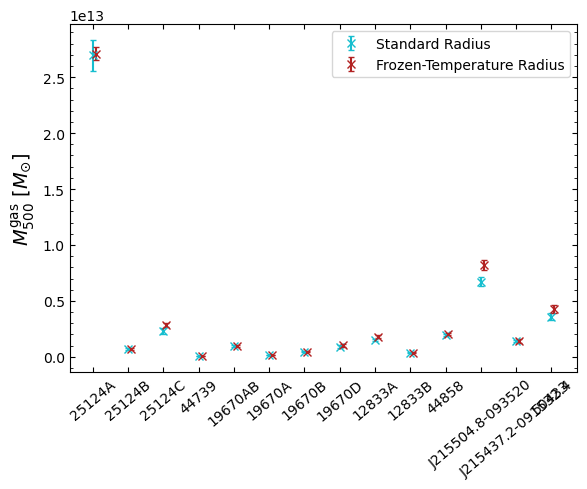

In [16]:
x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.errorbar(range(len(srcs)), gm500[:, 0].value, yerr=gm500[:, 1:].T.value, fmt='x', label="Standard Radius", 
             color=stand_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) + x_offset, froztemp_gm500[:, 0].value, 
             yerr=froztemp_gm500[:, 1:].T.value, fmt='x', 
             label="Frozen-Temperature Radius", color=froztemp_col, capsize=2)

plt.ylabel(r"$M^{\rm{gas}}_{500}$ [$M_{\odot}$]", fontsize=14)

plt.xticks(ticks=range(len(srcs)), labels=srcs.names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/gm_prop_comparisons/gm500_comp.pdf')
plt.show()

### $R_{2500}$

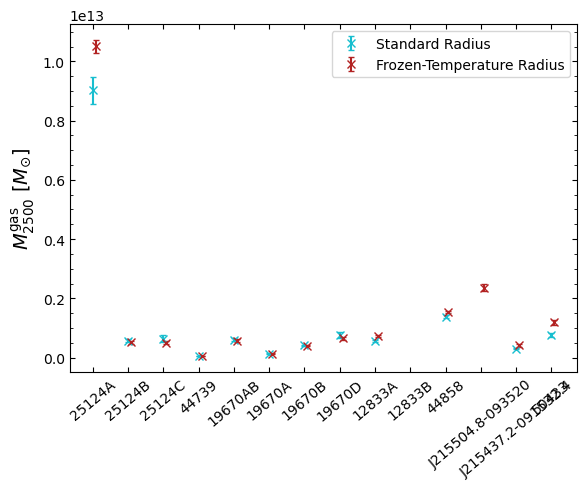

In [17]:
x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.errorbar(range(len(srcs)), gm2500[:, 0].value, yerr=gm2500[:, 1:].T.value, fmt='x', label="Standard Radius", 
             color=stand_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) + x_offset, froztemp_gm2500[:, 0].value, 
             yerr=froztemp_gm2500[:, 1:].T.value, fmt='x', 
             label="Frozen-Temperature Radius", color=froztemp_col, capsize=2)

plt.ylabel(r"$M^{\rm{gas}}_{2500}$ [$M_{\odot}$]", fontsize=14)

plt.xticks(ticks=range(len(srcs)), labels=srcs.names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/gm_prop_comparisons/gm2500_comp.pdf')
plt.show()

## Repeating profile and gas mass measurements without PSF correction

Many of the systems that we are attempting to analyse have been observed with quite low signal-to-noise, as they are low-mass and the archival data we are using wasn't necessarily taken with analysis of the groups in mind. In these circumstances, PSF correction can become unstable, so perform an additional measurement of the density profiles (and from there the gas masses) with PSF correction disabled.

### Density profiles without PSF correction

In [18]:
nopsf_d_profs = inv_abel_fitted_model(srcs, 'beta', outer_radius=srcs.r500, psf_corr=False, pix_step=2, 
                                      min_counts=25, conv_temp=txs)

/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:157: UserWarning: All XSPEC operations had already been run.
  cluster_cr_conv(sources, conv_outer_radius, inner_radius, temps, abund_table=abund_table, num_cores=num_cores,
Fitting data, inverse Abel transforming, and measuring densities:  43%|████▎     | 6/14 [01:48<02:21, 17.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 582.58369142  780.0886127  1229.14497568]


Fitting data, inverse Abel transforming, and measuring densities:  93%|█████████▎| 13/14 [03:59<00:18, 18.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [251.08983263 435.59670829 659.16719625]


Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████| 14/14 [04:16<00:00, 18.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 600.500013   1383.76835623 1511.80835881]


Once again we plot the surface brightness profiles, though these are without PSF correction: 

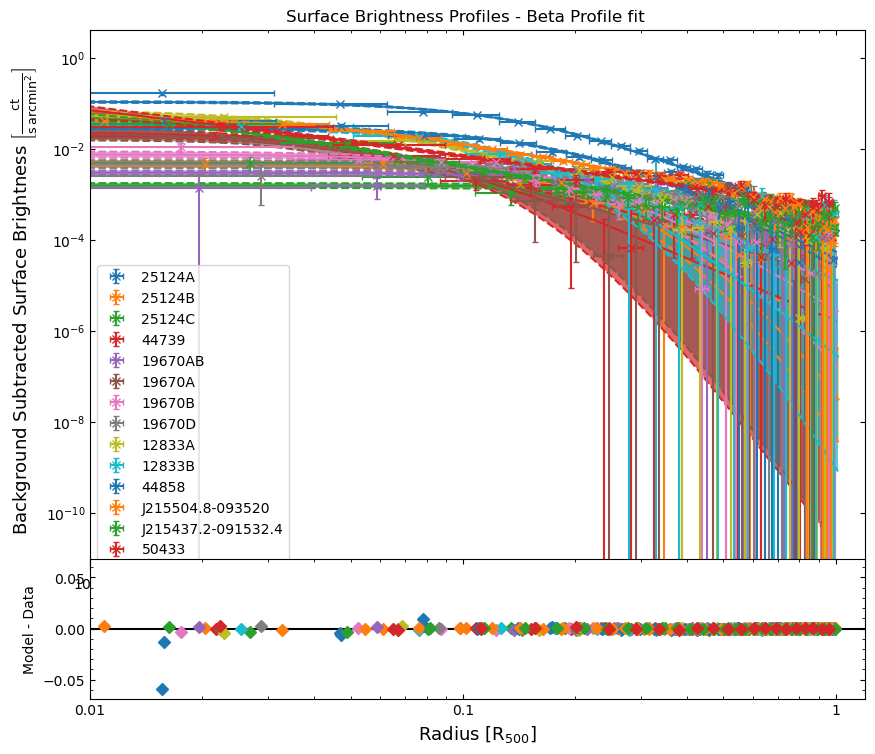

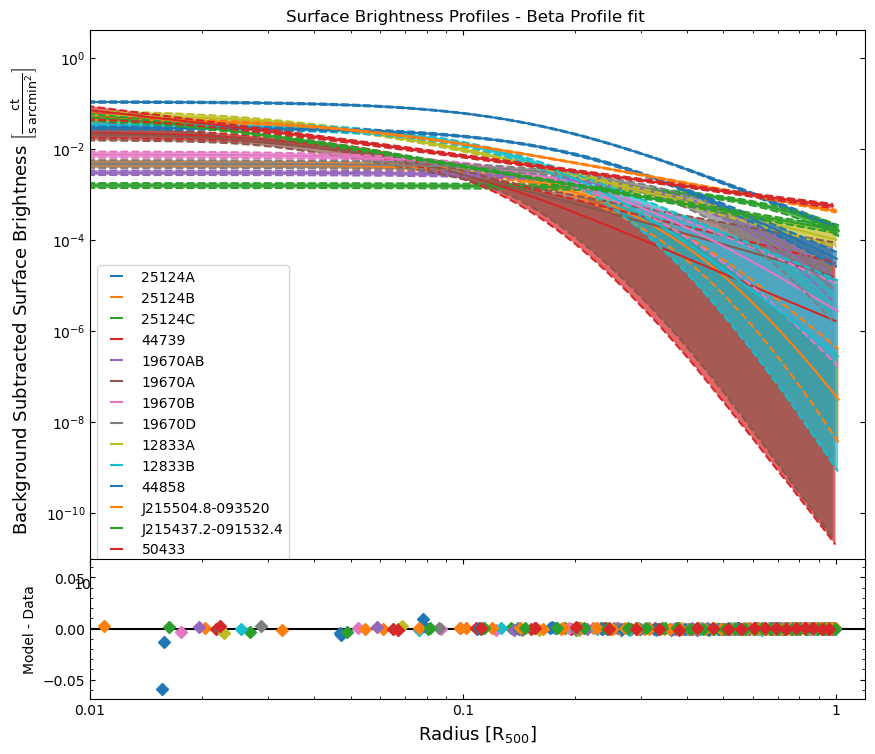

In [21]:
nopsf_sb_profs = []
for dp in nopsf_d_profs:
    if dp is not None:
        dp.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        dp.generation_profile.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        nopsf_sb_profs.append(dp.generation_profile)

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
BaseAggregateProfile1D(nopsf_sb_profs).view(model='beta', just_model=False, x_norm=True, axis_formatters=forms, 
                                            xlim=[0.01, 1.2], 
                                            save_path='../../outputs/figures/nopsf_sb_profs.pdf')
BaseAggregateProfile1D(nopsf_sb_profs).view(model='beta', just_model=True, x_norm=True, axis_formatters=forms, 
                                            xlim=[0.01, 1.2], 
                                            save_path='../../outputs/figures/nopsf_sb_profs_justmod.pdf')

### Gas masses without PSF correction

In [19]:
nopsf_gm500 = []
nopsf_gm2500 = []
nopsf_froztemp_gm500 = []
nopsf_froztemp_gm2500 = []

for dp in nopsf_d_profs:
    if dp is not None:
        rel_src = srcs[dp.src_name]
        dp.fit('king', progress_bar=False)
        r500_err = Quantity(r500_samp[r500_samp['name'] == rel_src.name].iloc[0]['r500+-'], 'kpc')
        nopsf_gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
        
        rel_rad = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500'], 'kpc')
        rel_rad_err = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500+-'], 'kpc')
        nopsf_gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        rel_rad = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == rel_src.name].iloc[0]['r500'], 'kpc')
        rel_rad_err = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == 
                                                  rel_src.name].iloc[0]['r500+-'], 'kpc')
        nopsf_froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        
        rel_rad = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == rel_src.name].iloc[0]['r2500'], 
                           'kpc')
        rel_rad_err = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == 
                                                   rel_src.name].iloc[0]['r2500+-'], 'kpc')
        nopsf_froztemp_gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
    else:
        null_res = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        nopsf_gm500.append(null_res)
        nopsf_gm2500.append(null_res)
        nopsf_froztemp_gm500.append(null_res)
        nopsf_froztemp_gm2500.append(null_res)
    
nopsf_gm500 = Quantity(nopsf_gm500)
nopsf_gm500[nopsf_gm500 == 0] = np.NaN
nopsf_gm2500 = Quantity(nopsf_gm2500)
nopsf_gm2500[nopsf_gm2500 == 0] = np.NaN

nopsf_froztemp_gm500 = Quantity(nopsf_froztemp_gm500)
nopsf_froztemp_gm500[nopsf_froztemp_gm500 == 0] = np.NaN
nopsf_froztemp_gm2500 = Quantity(nopsf_froztemp_gm2500)
nopsf_froztemp_gm2500[nopsf_froztemp_gm2500 == 0] = np.NaN

/tmp/local/48014095/ipykernel_1140215/3401096944.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  nopsf_gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/48014095/ipykernel_1140215/3401096944.py:20: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  nopsf_froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
/tmp/local/48014095/ipykernel_1140215/3401096944.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  nopsf_gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/48014095/ipykernel_1140215/3401096944.py:11: UserWarning: The outer radius you suppli

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [189.57734319 605.66222919 719.75480838]


/tmp/local/48014095/ipykernel_1140215/3401096944.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  nopsf_gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/48014095/ipykernel_1140215/3401096944.py:20: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  nopsf_froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 613.05242078 2339.60390456 2525.54442677]


/tmp/local/48014095/ipykernel_1140215/3401096944.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  nopsf_gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/48014095/ipykernel_1140215/3401096944.py:20: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  nopsf_froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])


We also view the density profiles:

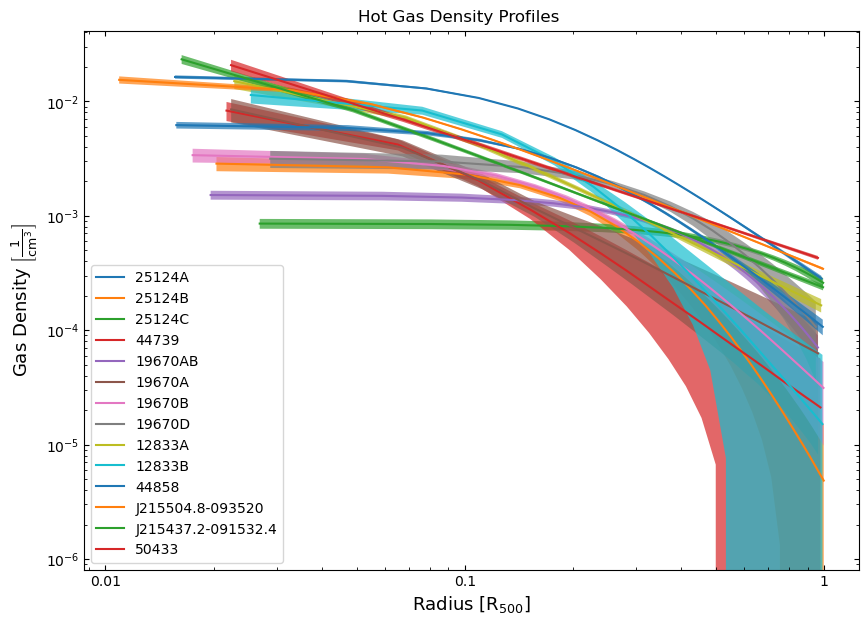

In [22]:
agg_dp = BaseAggregateProfile1D([dp for dp in nopsf_d_profs if dp is not None])

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
agg_dp.view(joined_points=True, custom_title='Hot Gas Density Profiles', x_norm=True, axis_formatters=forms,
            save_path='../../outputs/figures/nopsf_hot_gas_dens_profs.pdf')

Saving the gas masses derived from profiles that **are not** corrected for PSF effects:

In [20]:
nopsf_gm_data = (np.hstack([nopsf_gm500, nopsf_gm2500, nopsf_froztemp_gm500, 
                            nopsf_froztemp_gm2500]).value / 1e+13).round(4)
nopsf_gm_data = np.hstack([srcs.names[..., None], nopsf_gm_data])

gm_cols = ['name', 'gm500', 'gm500-', 'gm500+', 'gm2500', 'gm2500-', 'gm2500+', 
           'gm_froztemp500', 'gm_froztemp500-', 'gm_froztemp500+', 'gm_froztemp2500', 'gm_froztemp2500-', 
           'gm_froztemp2500+']

nopsf_gm_pd = pd.DataFrame(nopsf_gm_data, columns=gm_cols)
nopsf_gm_pd.to_csv("../../outputs/results/nopsf_all_hot_gm_measurements.csv", index=False)
nopsf_gm_pd

,name,gm500,gm500-,gm500+,gm2500,gm2500-,gm2500+,gm_froztemp500,gm_froztemp500-,gm_froztemp500+,gm_froztemp2500,gm_froztemp2500-,gm_froztemp2500+
0,25124A,3.0544,0.1565,0.1503,1.0177,0.0524,0.0533,3.0731,0.0618,0.0633,1.1873,0.025,0.0253
1,25124B,0.1412,0.0115,0.0119,0.0954,0.0082,0.008,0.1353,0.0091,0.0089,0.0838,0.0048,0.0049
2,25124C,0.3385,0.0326,0.0325,0.0897,0.0144,0.0152,0.4199,0.0258,0.026,0.0707,0.0067,0.0072
3,44739,0.0307,0.0065,0.0068,0.0147,0.0018,0.0018,0.0386,0.0097,0.0102,0.0188,0.0027,0.0026
4,19670AB,0.2189,0.0114,0.0115,0.0925,0.0095,0.0096,0.2205,0.0092,0.0096,0.0876,0.0062,0.0063
5,19670A,0.0766,0.0132,0.0144,0.0286,0.0043,0.0048,0.0776,0.0132,0.0151,0.0287,0.0032,0.0034
6,19670B,0.1667,0.0128,0.0142,0.0874,0.0069,0.0068,0.1612,0.0098,0.0102,0.0779,0.0039,0.0041
7,19670D,0.0995,0.0129,0.0141,0.0878,0.0108,0.0108,0.1147,0.0141,0.0171,0.0738,0.0049,0.0051
8,12833A,0.2292,0.0159,0.017,0.0713,0.0041,0.0043,0.2823,0.0177,0.0181,0.0948,0.0052,0.0053
9,12833B,0.0661,0.0113,0.0117,nan,nan,nan,0.069,0.0131,0.0139,nan,nan,nan
